In [4]:
# read csv file
import csv

processed_row = []
with open('adult100.csv', 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # 跳过标题行
    for row in csv_reader:
        # 每行数据处理
        headers = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
                  'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                  'hours-per-week', 'native-country', 'income']
        selected_values = [r for r in row]
        # headers = ['workclass', 'education', 'marital-status', 
        #           'occupation', 'relationship', 'race', 'sex',
        #           'native-country']
        # # 根据headers中指定的列索引获取对应的值
        # selected_values = [row[1], row[3], row[5], row[6], row[7], row[8], row[9], row[13]]
        temp_dict = dict(zip(headers, selected_values))
        processed_row.append(temp_dict)

print(processed_row[0])


{'age': '39', 'workclass': 'State-gov', 'fnlwgt': '77516', 'education': 'Bachelors', 'education-num': '13', 'marital-status': 'Never-married', 'occupation': 'Adm-clerical', 'relationship': 'Not-in-family', 'race': 'White', 'sex': 'Male', 'capital-gain': '2174', 'capital-loss': '0', 'hours-per-week': '40', 'native-country': 'United-States', 'income': '<=50K'}


In [7]:
# 导入所需库
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
import torch

# 初始化tokenizer和模型
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('distilgpt2')

# 准备训练数据
# 将字典数据转换为文本格式
texts = []
import json

# 将数据转换为JSON字符串
# 直接从processed_row创建数据集
from torch.utils.data import Dataset

class AdultDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # 将字典转换为格式化的JSON字符串
        text = json.dumps(self.data[idx], ensure_ascii=False, sort_keys=True)
        # 对文本进行编码
        encodings = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )
        # 创建attention_mask
        attention_mask = torch.ones_like(encodings['input_ids'])
        attention_mask[encodings['input_ids'] == tokenizer.pad_token_id] = 0
        encodings['attention_mask'] = attention_mask
        
        # 创建labels (与input_ids相同,用于语言模型训练)
        encodings['labels'] = encodings['input_ids'].clone()
        return encodings

# 创建数据集
train_dataset = AdultDataset(processed_row, tokenizer)

print(f"训练数据集大小: {len(train_dataset)}")

# 创建数据收集器
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

训练数据集大小: 100


/root/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
10,2.239900
20,1.057600
30,0.620500
40,0.460900
50,0.397000
60,0.346700
70,0.344700
80,0.339700
90,0.307000
100,0.304600


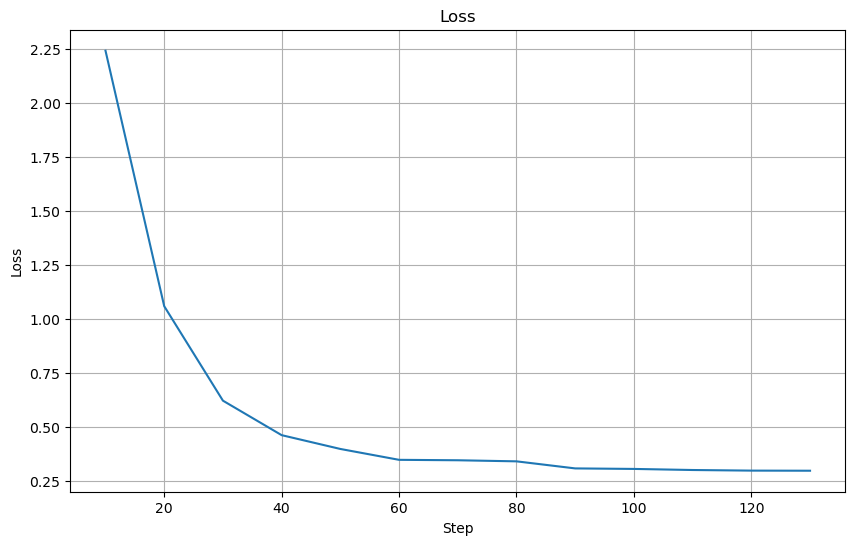

('./gpt2-adult-data-final/tokenizer_config.json',
 './gpt2-adult-data-final/special_tokens_map.json',
 './gpt2-adult-data-final/vocab.json',
 './gpt2-adult-data-final/merges.txt',
 './gpt2-adult-data-final/added_tokens.json')

In [8]:
# 设置训练参数
training_args = TrainingArguments(
    output_dir="./gpt2-adult-data",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=1,
    save_steps=500,
    save_total_limit=2,
    logging_dir='./logs',  # 添加日志目录
    logging_steps=10,      # 每10步记录一次loss
    learning_rate=5e-5,  # 添加学习率
)

# 创建训练器
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

# 开始训练
train_result = trainer.train()

# 绘制loss曲线
import pandas as pd
import matplotlib.pyplot as plt

# 读取训练日志
log_history = pd.DataFrame(trainer.state.log_history)
train_loss = log_history[log_history['loss'].notna()]

plt.figure(figsize=(10, 6))
plt.plot(train_loss['step'], train_loss['loss'])
plt.title('Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# 保存模型
model.save_pretrained("./gpt2-adult-data-final")
tokenizer.save_pretrained("./gpt2-adult-data-final")

In [11]:
from transformers import GPT2LMHeadModel

# 加载模型和分词器
model = GPT2LMHeadModel.from_pretrained("./gpt2-adult-data-final")
tokenizer = GPT2Tokenizer.from_pretrained("./gpt2-adult-data-final")

# 设置生成参数
input_text = '{"'
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# 生成文本
output = model.generate(
    input_ids,
    max_length=128,
    num_return_sequences=100,
    no_repeat_ngram_size=3,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    temperature=0.7,
    pad_token_id=tokenizer.eos_token_id,
    attention_mask=torch.ones_like(input_ids)  # 添加attention_mask
)

# store output as a list and store as json
# 将生成的文本转换为列表
generated_texts = []
for i in range(len(output)):
    text = tokenizer.decode(output[i], skip_special_tokens=True)
    generated_texts.append(text)

# 将生成的文本保存为JSON文件
import json
with open('generated_rows.json', 'w', encoding='utf-8') as f:
    json.dump(generated_texts, f, ensure_ascii=False, indent=4)

print("生成的文本已保存到 generated_texts.json")



生成的文本已保存到 generated_texts.json


In [8]:
import json
import re

# 读取JSON文件
with open('generated_rows.json', 'r', encoding='utf-8') as f:
    generated_texts = json.load(f)

# 用于存储有效的JSON对象
valid_jsons = []

# 遍历生成的文本
for text in generated_texts:
    # 使用非贪婪匹配查找所有的JSON对象
    matches = re.findall(r'{.*?}', text, re.DOTALL)
    
    # 遍历找到的所有可能的JSON字符串
    for match in matches:
        try:
            # 尝试解析JSON
            json_obj = json.loads(match)
            # 将数值型字段从字符串转换为整数
            numeric_fields = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
            for field in numeric_fields:
                if field in json_obj:
                    try:
                        json_obj[field] = int(json_obj[field])
                    except (ValueError, TypeError):
                        continue
            valid_jsons.append(json_obj)
        except json.JSONDecodeError:
            continue

print(f"\n总共找到 {len(valid_jsons)} 个有效的JSON对象")

# store valid_jsons as a json file
with open('valid_jsons.json', 'w', encoding='utf-8') as f:
    json.dump(valid_jsons, f, ensure_ascii=False, indent=4)



总共找到 98 个有效的JSON对象


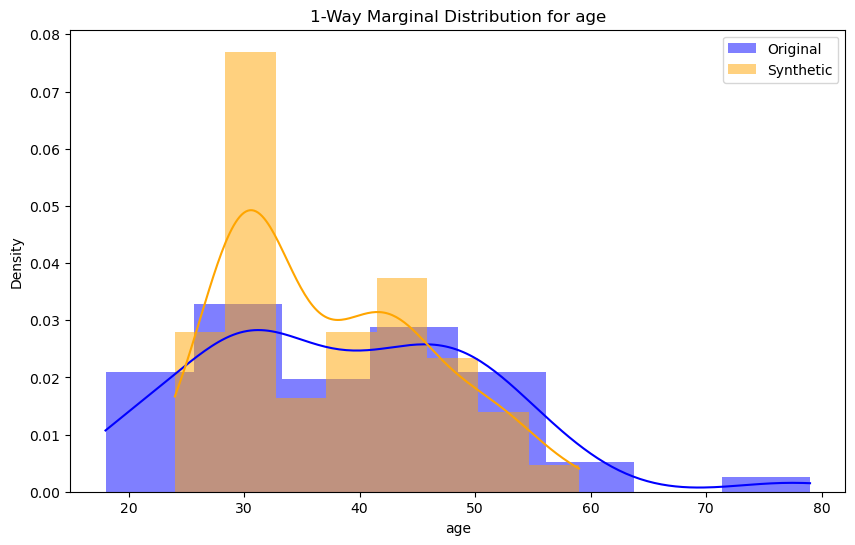

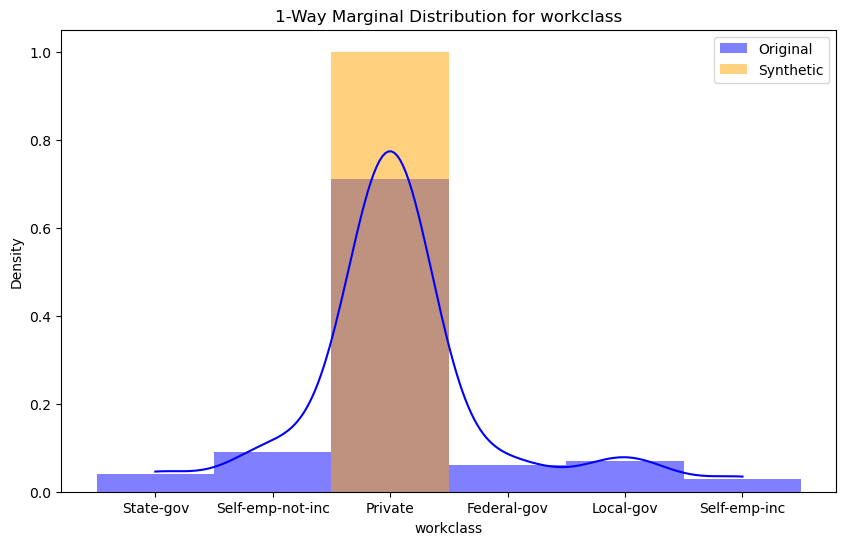

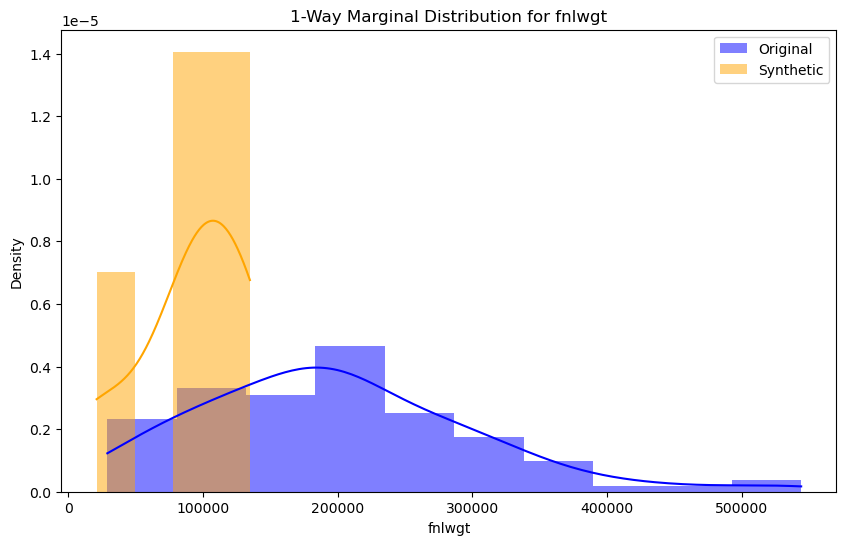

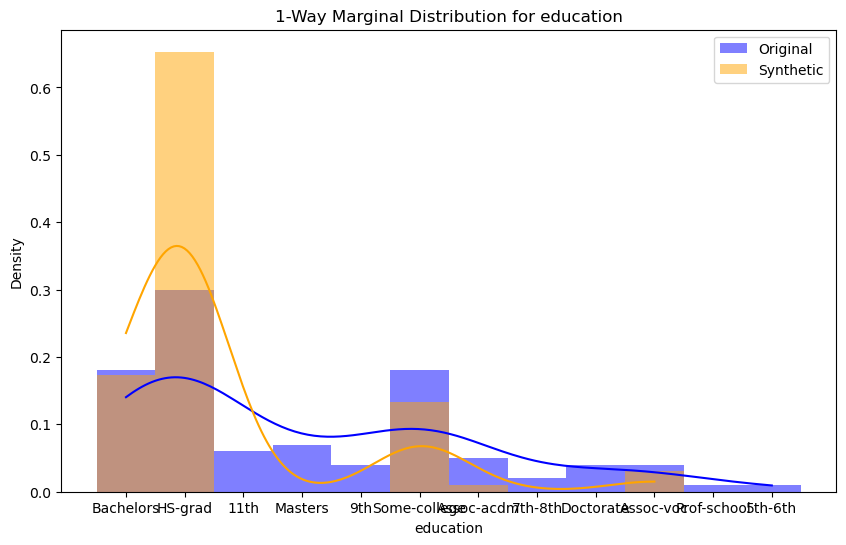

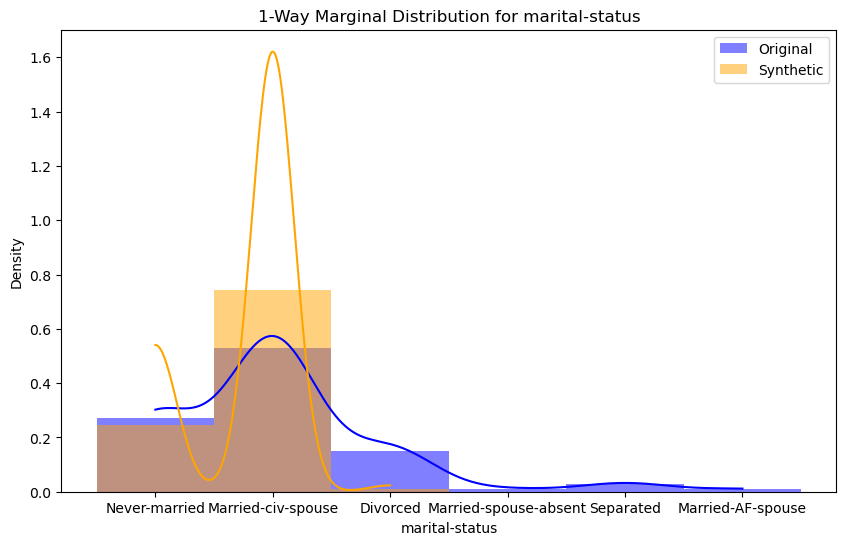

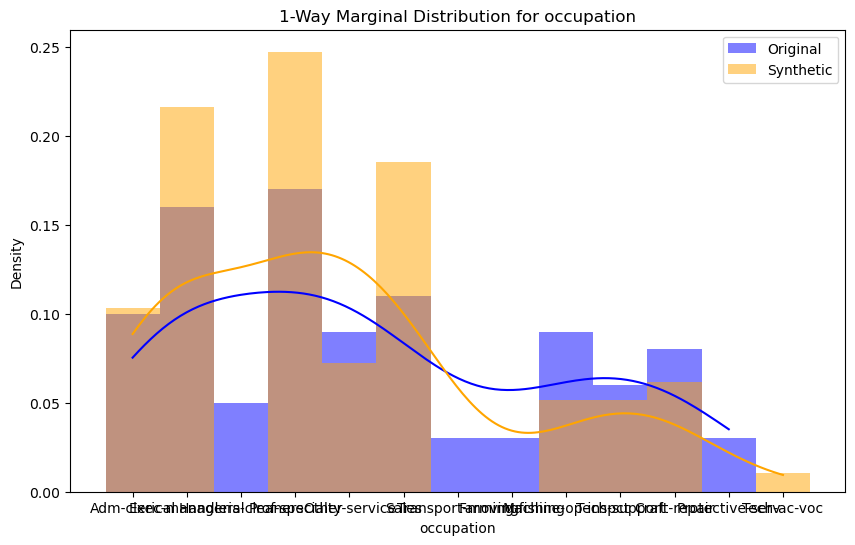

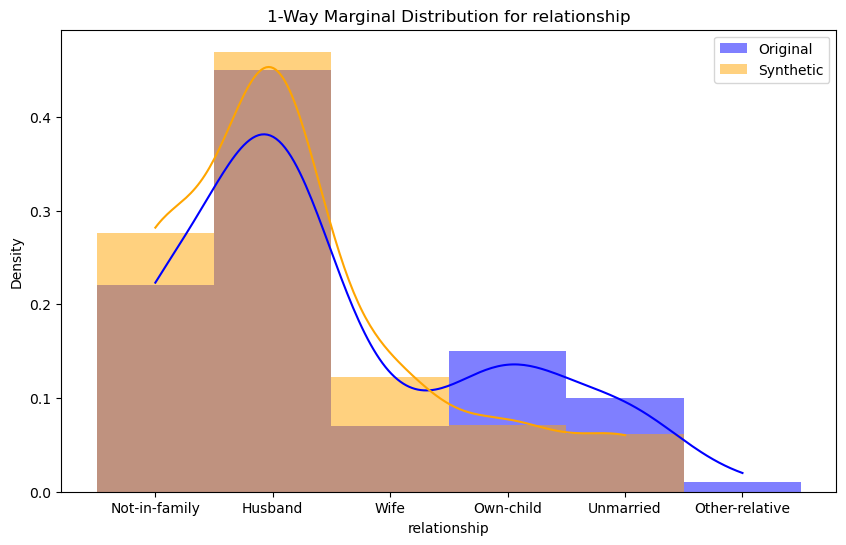

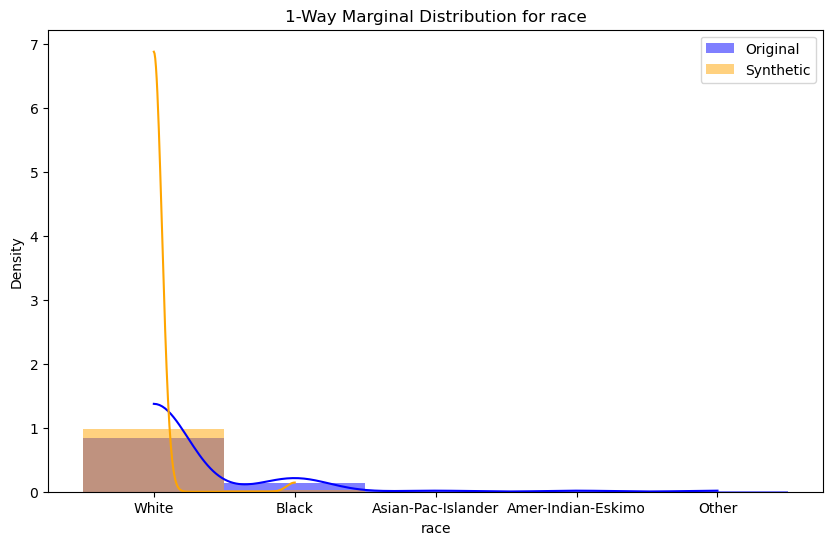

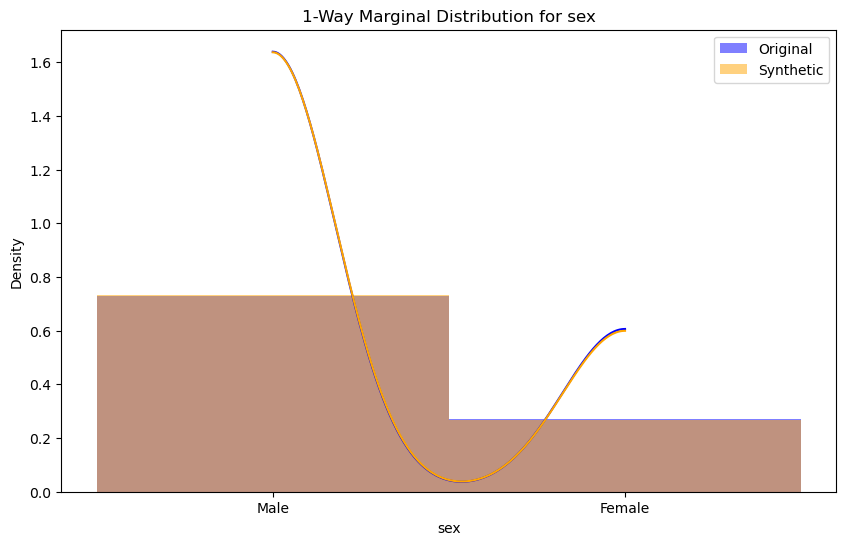

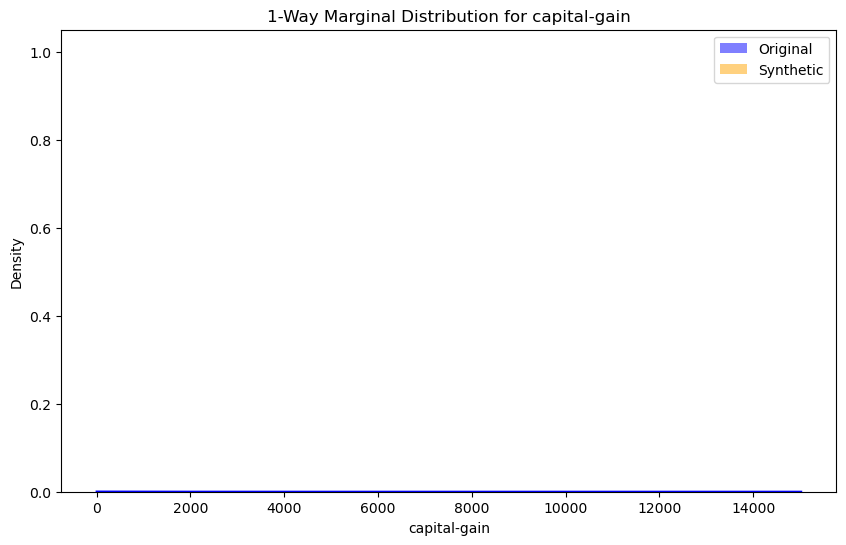

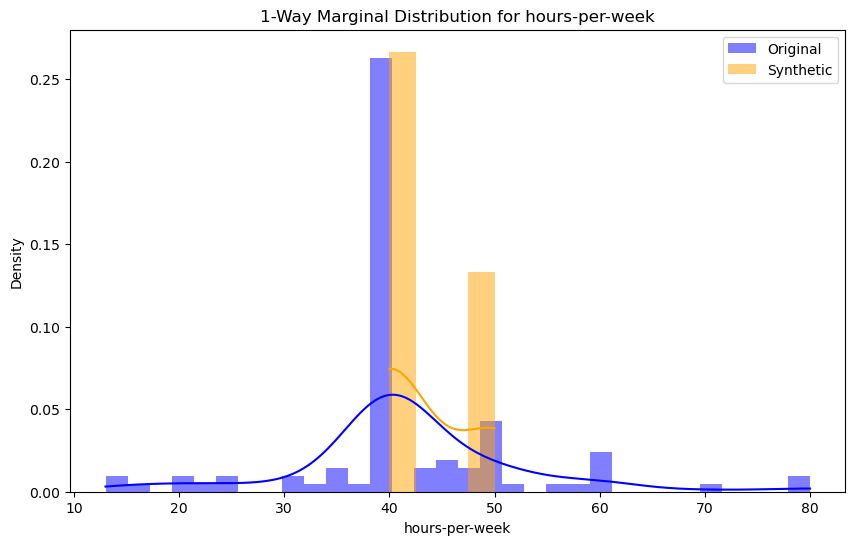

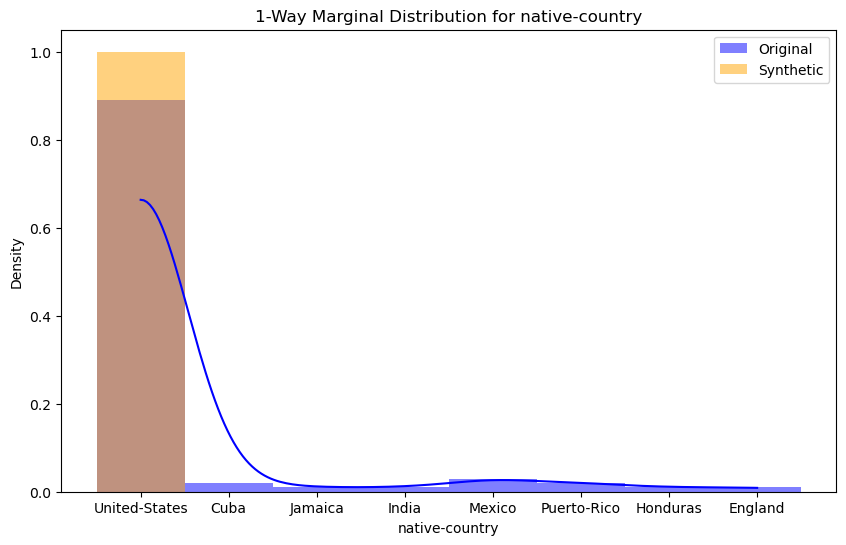

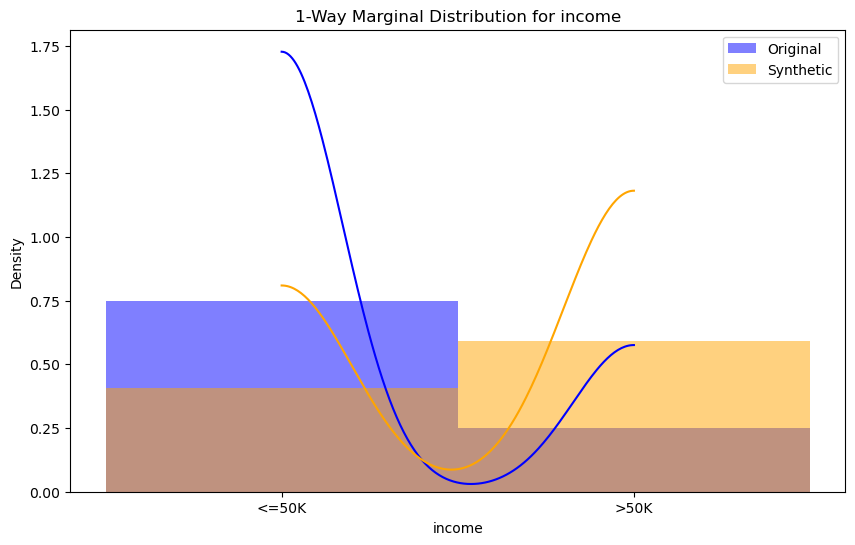

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# 读取原始CSV数据
original_data = pd.read_csv('adult100.csv')

# 假设你的生成数据是这样的格式：
# generated_data = [
#     {'workclass': 'Private', 'education': 'Bachelors', ...},
#     {'workclass': 'State-gov', 'education': 'Masters', ...},
#     ...
# ]

# 将生成的字典列表转换为DataFrame
synthetic_data = pd.DataFrame(valid_jsons)

# 1. 单变量边际分布比较
def plot_1_way_marginal(original_data, synthetic_data, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(original_data[column], color='blue', label='Original', kde=True, stat="density", linewidth=0)
    sns.histplot(synthetic_data[column], color='orange', label='Synthetic', kde=True, stat="density", linewidth=0)
    plt.title(f'1-Way Marginal Distribution for {column}')
    plt.legend()
    plt.show()

# 对每个特征进行比较
for column in original_data.columns:
    if column in synthetic_data.columns:  # 确保特征在合成数据中也存在
        plot_1_way_marginal(original_data, synthetic_data, column)

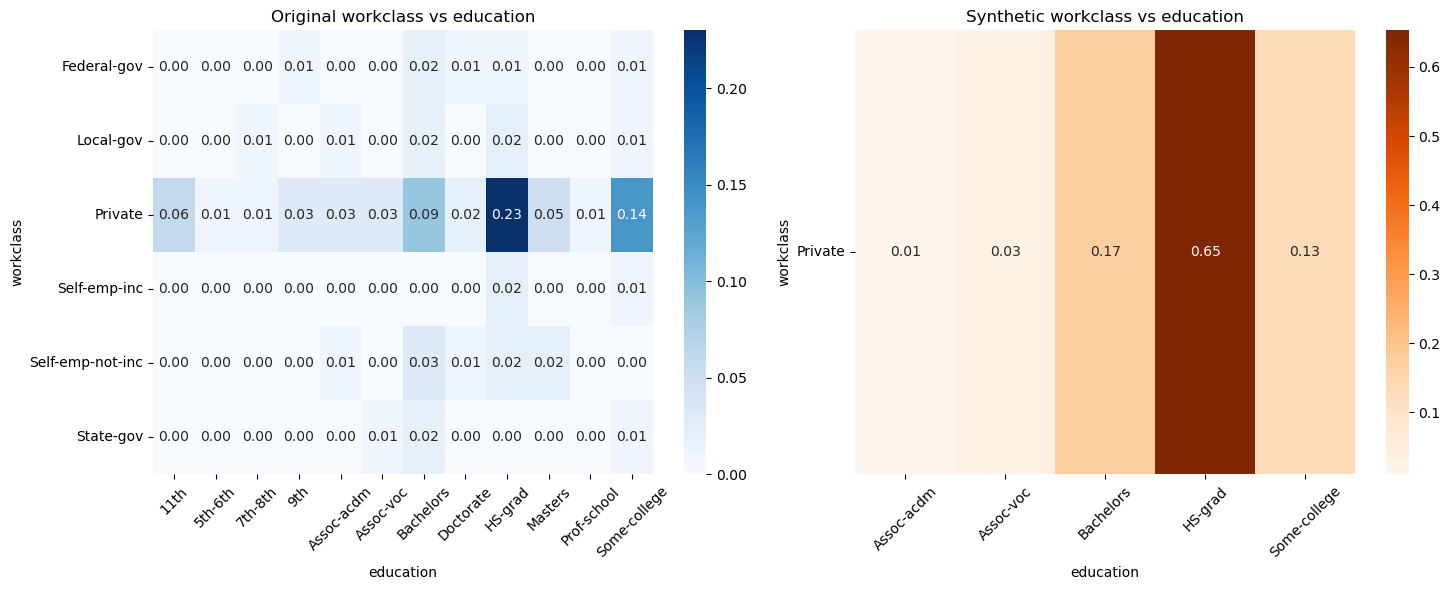


Distribution difference for workclass vs education:
Mean absolute difference: 0.1069
Maximum difference: 0.4231


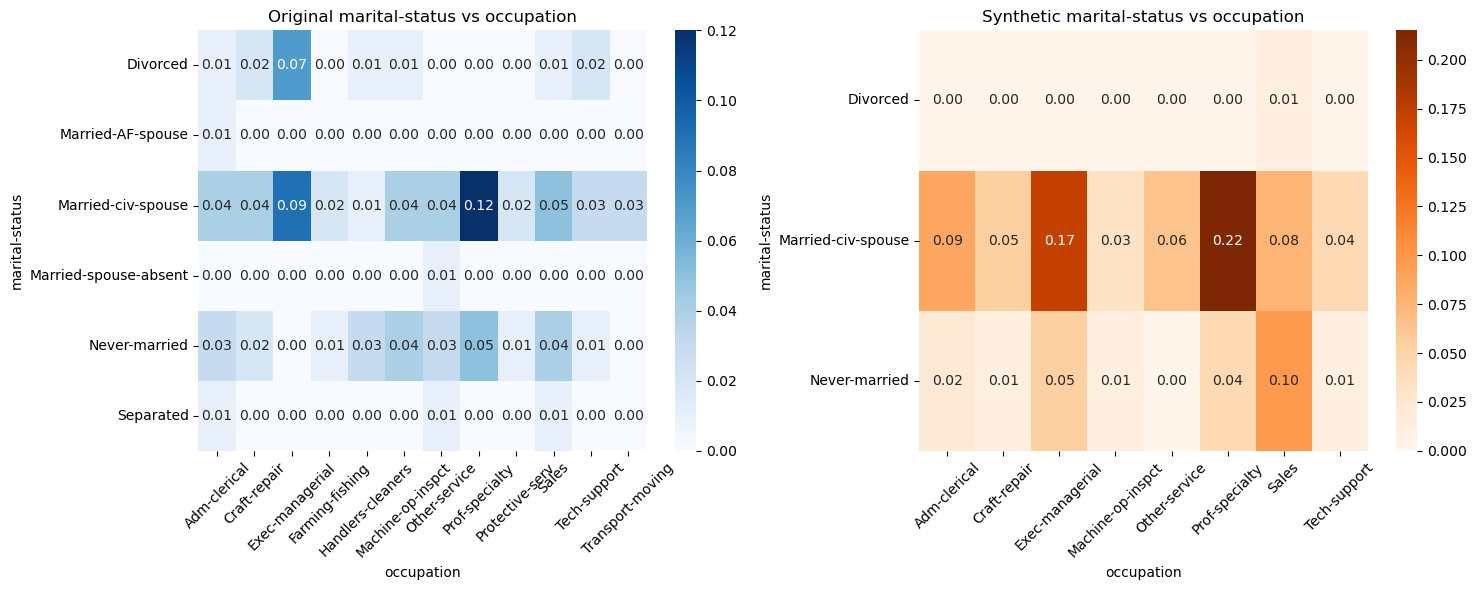


Distribution difference for marital-status vs occupation:
Mean absolute difference: 0.0264
Maximum difference: 0.0951


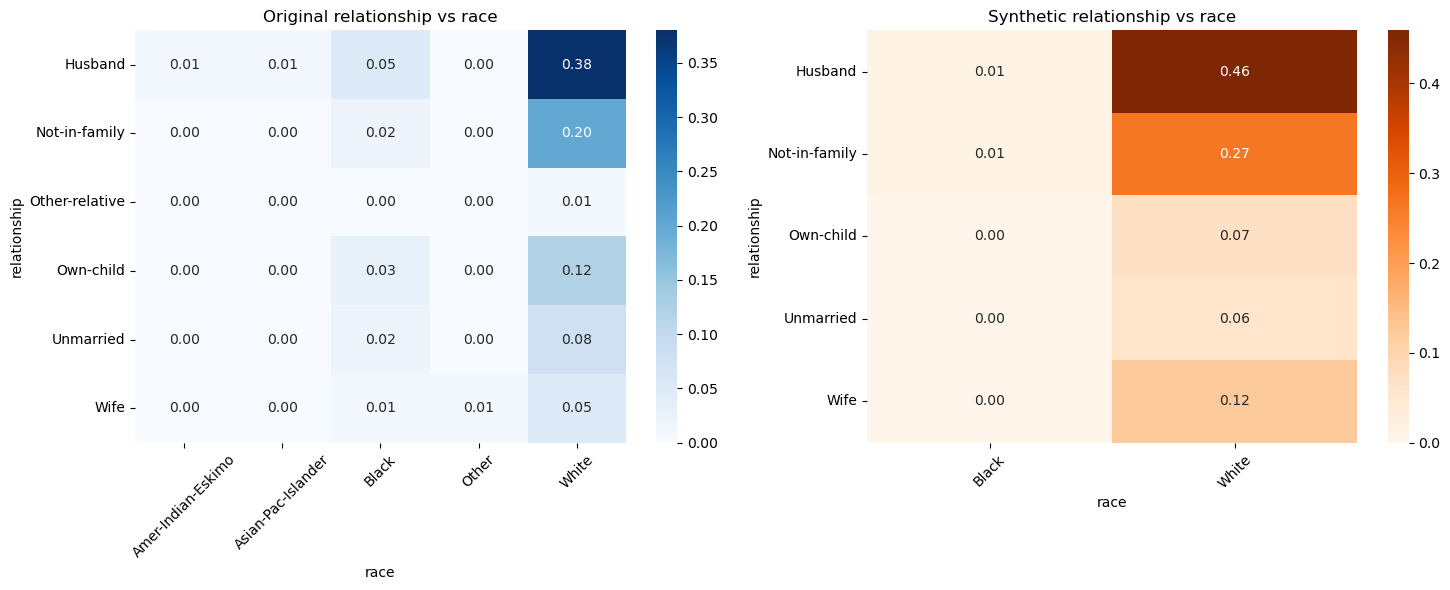


Distribution difference for relationship vs race:
Mean absolute difference: 0.0394
Maximum difference: 0.0792


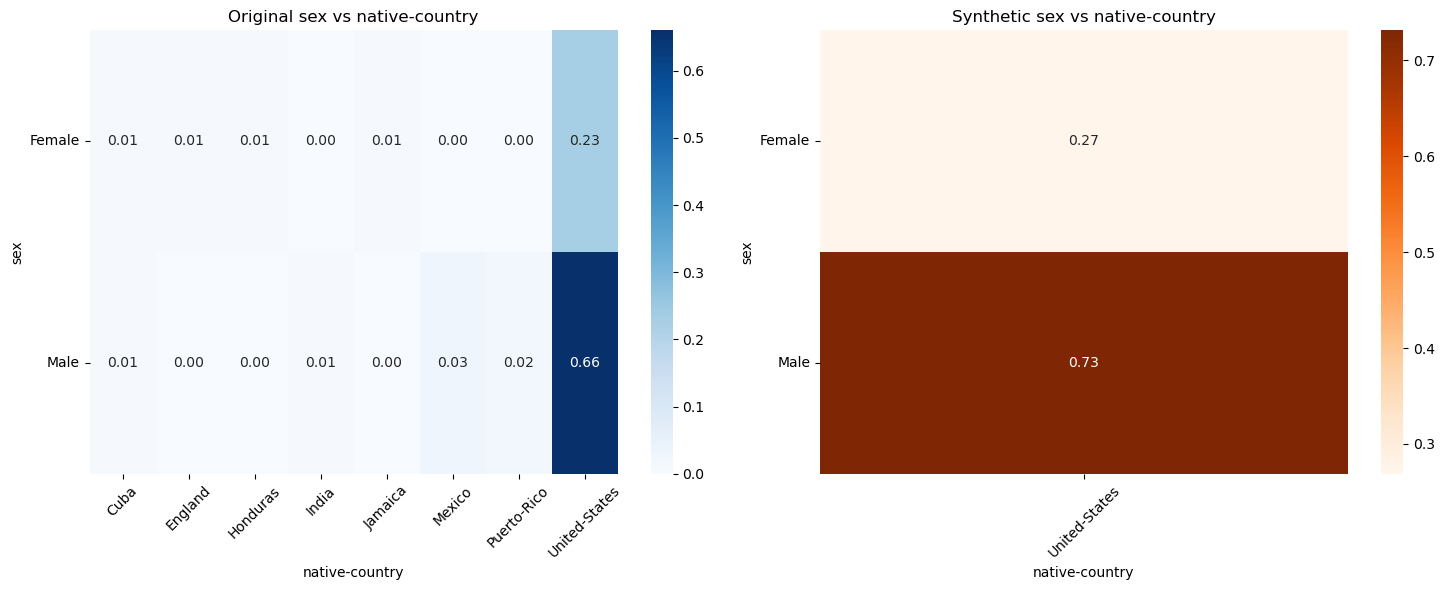


Distribution difference for sex vs native-country:
Mean absolute difference: 0.0550
Maximum difference: 0.0712

Statistics for age:
Original Data:
18    0.02
19    0.03
20    0.02
21    0.01
22    0.01
23    0.03
24    0.01
25    0.03
27    0.01
28    0.03
29    0.05
30    0.06
31    0.05
32    0.04
33    0.01
34    0.02
35    0.02
36    0.01
37    0.04
38    0.02
39    0.02
40    0.02
41    0.02
42    0.02
43    0.04
44    0.03
45    0.01
46    0.02
47    0.03
48    0.05
49    0.05
50    0.02
52    0.02
53    0.05
54    0.01
56    0.01
57    0.02
59    0.02
76    0.01
79    0.01
Name: age, dtype: float64

Synthetic Data:
24    0.010204
25    0.030612
27    0.030612
28    0.051020
29    0.071429
30    0.040816
31    0.132653
32    0.091837
33    0.010204
34    0.020408
35    0.010204
37    0.030612
38    0.051020
39    0.020408
40    0.040816
41    0.010204
42    0.020408
43    0.091837
44    0.040816
45    0.010204
46    0.010204
47    0.010204
48    0.030612
49    0.020408
50    0.0

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_2_way_marginal(original_data, synthetic_data, column1, column2):
    if column1 in synthetic_data.columns and column2 in synthetic_data.columns:
        plt.figure(figsize=(15, 6))
        
        # 计算联合分布
        original_joint = pd.crosstab(original_data[column1], original_data[column2], normalize='all')
        synthetic_joint = pd.crosstab(synthetic_data[column1], synthetic_data[column2], normalize='all')
        
        # 创建子图
        plt.subplot(1, 2, 1)
        sns.heatmap(original_joint, annot=True, fmt='.2f', cmap='Blues')
        plt.title(f'Original {column1} vs {column2}')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        
        plt.subplot(1, 2, 2)
        sns.heatmap(synthetic_joint, annot=True, fmt='.2f', cmap='Oranges')
        plt.title(f'Synthetic {column1} vs {column2}')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        
        plt.tight_layout()
        plt.show()
        
        # 计算分布差异
        diff = np.abs(original_joint - synthetic_joint)
        print(f"\nDistribution difference for {column1} vs {column2}:")
        print(f"Mean absolute difference: {diff.mean().mean():.4f}")
        print(f"Maximum difference: {diff.max().max():.4f}")

# 选择要比较的特征对
feature_pairs = [
    ('workclass', 'education'),
    ('marital-status', 'occupation'),
    ('relationship', 'race'),
    ('sex', 'native-country')
]

for column1, column2 in feature_pairs:
    plot_2_way_marginal(original_data, synthetic_data, column1, column2)

# 计算统计指标
def calculate_statistics(original_data, synthetic_data, column):
    if column in synthetic_data.columns:
        print(f"\nStatistics for {column}:")
        print("Original Data:")
        print(original_data[column].value_counts(normalize=True).sort_index())
        print("\nSynthetic Data:")
        print(synthetic_data[column].value_counts(normalize=True).sort_index())
        
        # 计算分布差异
        original_dist = original_data[column].value_counts(normalize=True)
        synthetic_dist = synthetic_data[column].value_counts(normalize=True)
        
        # 确保两个分布有相同的索引
        all_categories = set(original_dist.index) | set(synthetic_dist.index)
        original_dist = original_dist.reindex(all_categories, fill_value=0)
        synthetic_dist = synthetic_dist.reindex(all_categories, fill_value=0)
        
        # 计算差异
        diff = np.abs(original_dist - synthetic_dist)
        print(f"\nDistribution difference:")
        print(f"Mean absolute difference: {diff.mean():.4f}")
        print(f"Maximum difference: {diff.max():.4f}")

# 对每个特征计算统计指标
for column in original_data.columns:
    if column in synthetic_data.columns:
        calculate_statistics(original_data, synthetic_data, column)